# Introduction to Raster Data

### Setup

In [156]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import mapping
import seaborn as sns
import pandas as pd
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
#import xvec
import osmnx as ox

In [138]:
data_dir = "/Users/robmarty/Dropbox/World Bank/Trainings and Code Resources/LAMATA Workshop 2024/Data"

### Load and explore data

#### GADM data

In [139]:
lagos_adm1_gdf = gpd.read_file(data_dir + "/GADM/" + "Raw/" + "lagos_adm1.geojson")
lagos_adm2_gdf = gpd.read_file(data_dir + "/GADM/" + "Raw/" + "lagos_adm2.geojson")

#### Gridded population data (World Pop)

In [140]:
wp_dir = data_dir + "/WorldPop/" + "Raw/" + "NGA_population_v2_1_gridded.tif"

In [141]:
r = rxr.open_rasterio(wp_dir)

### Explore raster data

In [142]:
r

<xarray.DataArray (band: 1, y: 11546, x: 14413)> Size: 666MB
[166412498 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 115kB 2.669 2.67 2.671 2.672 ... 14.68 14.68 14.68
  * y            (y) float64 92kB 13.89 13.89 13.89 13.89 ... 4.273 4.272 4.271
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  2166.777816912809
    STATISTICS_MAXIMUM:      2641.578125
    STATISTICS_MEAN:         30.198772154914
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       46.548660742419
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

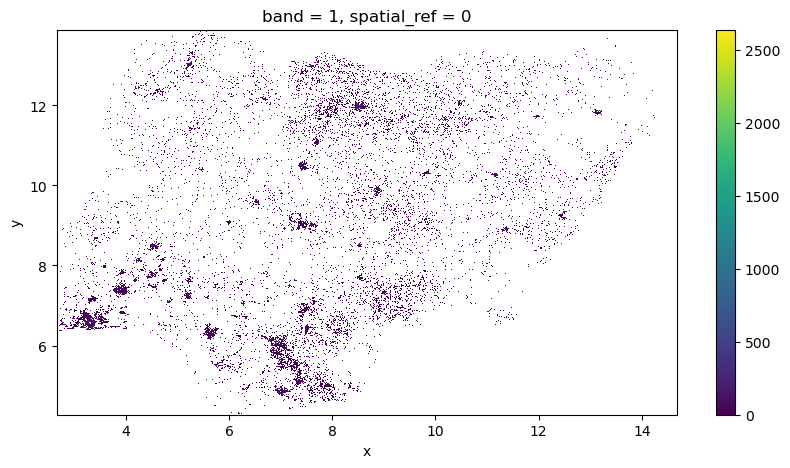

In [143]:
f, ax = plt.subplots(figsize=(10, 5))
r.squeeze().plot.imshow()

### Clip to Lagos

In [144]:
r_lagos = r.rio.clip(lagos_adm1_gdf.geometry.apply(mapping))

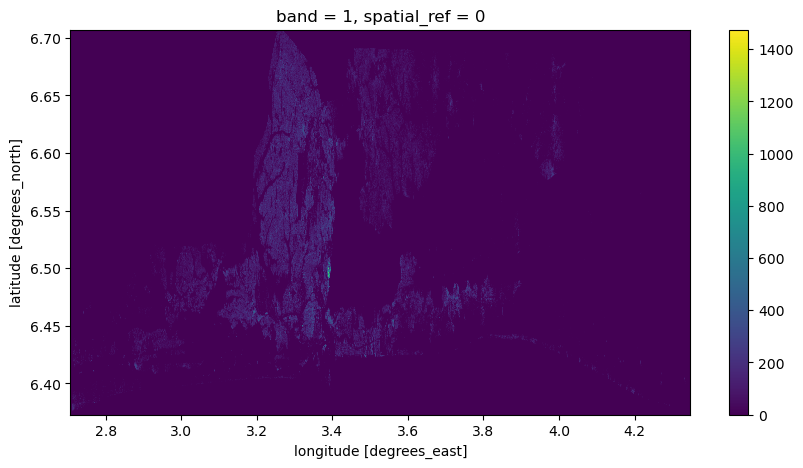

In [145]:
f, ax = plt.subplots(figsize=(10, 5))
r_lagos.squeeze().plot.imshow()

### Determine population of ADM2 locations

The raster data is a grid, where each grid cell has a population value. We sum the population gridded values within each ADM2 polygon.

In [146]:
pop_sum = r_lagos.xvec.zonal_stats(
    lagos_adm2_gdf.geometry, x_coords="x", y_coords="y", stats = "sum",
)

In [147]:
pop_sum

<xarray.DataArray (geometry: 20, band: 1)> Size: 80B
array([[ 229857.22 ],
       [ 107358.875],
       [1618275.9  ],
       [ 801815.1  ],
       [ 271015.25 ],
       [ 683798.06 ],
       [ 256703.5  ],
       [ 779365.5  ],
       [ 470104.56 ],
       [ 383702.   ],
       [ 458339.8  ],
       [1294525.8  ],
       [ 442419.9  ],
       [ 323051.94 ],
       [ 229058.88 ],
       [ 168001.16 ],
       [ 677467.94 ],
       [ 381577.38 ],
       [ 243401.53 ],
       [ 382402.22 ]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
  * geometry     (geometry) object 160B POLYGON ((3.301352979000114 6.6203908...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  2166.777816912809
    STATISTICS_MAXIMUM:      2641.578125
    STATISTICS_MEAN:         30.198772154914
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       46.548660742419
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0.0

In [148]:
lagos_adm2_gdf['pop'] = pop_sum
lagos_adm2_gdf.explore(column = "pop")

### Exercise 1: What is the proportion of the population that lives within 1km of a BRT bus stop?

#### Prep bus stop data

In [149]:
# Query bus stops from OSM
bus_gdf = ox.features.features_from_place(query = "Lagos, Nigeria",
                                tags = {'highway': 'bus_stop',
                                       'amenity': 'bus_station'})

# Buffer by 1km; need to convert to UTM for buffering
bus_gdf.geometry = bus_gdf.geometry.to_crs(32631).buffer(1000).to_crs(4326)

# Plot bus stops
bus_gdf.explore()

In [150]:
bus_diss_gdf = bus_gdf.dissolve()

In [151]:
bus_diss_gdf.explore()

#### Total population within 1km of BRT stops

In [152]:
bus_pop_sum = r_lagos.xvec.zonal_stats(
    bus_diss_gdf.geometry, x_coords="x", y_coords="y", stats = "sum",
)

bus_diss_gdf['pop'] = bus_pop_sum

#### Divide BRT pop by Lagos pop

In [154]:
brt_pop = bus_diss_gdf['pop'].sum() 
lagos_pop = lagos_adm2_gdf['pop'].sum()

brt_pop / lagos_pop * 100

15.668866038322449

### Exercise 2: What is the proportion of the population that lives within a 10 minute drive of a bus stop?

In [163]:
lagos_hex_gdf = gpd.read_file(data_dir + "/OSM Routing" + "/brt_access_hexs.geojson")

In [164]:
hex_pop_sum = r_lagos.xvec.zonal_stats(
    lagos_hex_gdf.geometry, x_coords="x", y_coords="y", stats = "sum",
)

lagos_hex_gdf['pop'] = hex_pop_sum

In [172]:
pop_within_10min = lagos_hex_gdf[lagos_hex_gdf['tt_nearest_busstop_min'] <= 10]['pop'].sum()
pop_over_10min   = lagos_hex_gdf[lagos_hex_gdf['tt_nearest_busstop_min'] > 10]['pop'].sum()

In [173]:
pop_within_10min / (pop_within_10min + pop_over_10min)

0.66996956